## Keras  MNIST Fashion Estimator Example

Single fully connected hidden layer exported for both prediction on training on device with tensor/io. Wraps the keras model in an estimator and uses the `experimental_mode` parameter to export for training. Relies on some `compat.v1` apis for optimization and loss functions.

Based on:

- https://www.tensorflow.org/tutorials/keras/classification
- https://www.tensorflow.org/guide/migrate#estimators

In [21]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

import PIL.Image as Image
import matplotlib.pylab as plt

%matplotlib inline

In [22]:
def enable_memory_growth():
    physical_devices = tf.config.experimental.list_physical_devices('GPU') 
    try: 
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        # tf.config.gpu.set_per_process_memory_growth(True)
        # tf.config.gpu.set_per_process_memory_fraction(0.75)
    except: 
        print('Invalid device or cannot modify virtual devices once initialized.')

        
if "TF_GPU_GROWTH" in os.environ:
    print("Enabling GPU memory growth")
    enable_memory_growth()

Enabling GPU memory growth
Invalid device or cannot modify virtual devices once initialized.


## Fashion MNIST

In [23]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [24]:
class_names = [
    'T-shirt/top', 
    'Trouser', 
    'Pullover', 
    'Dress', 
    'Coat',
    'Sandal', 
    'Shirt', 
    'Sneaker', 
    'Bag', 
    'Ankle boot'
]

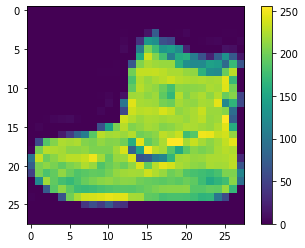

In [25]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [26]:
train_images = train_images / 255.0
test_images = test_images / 255.0

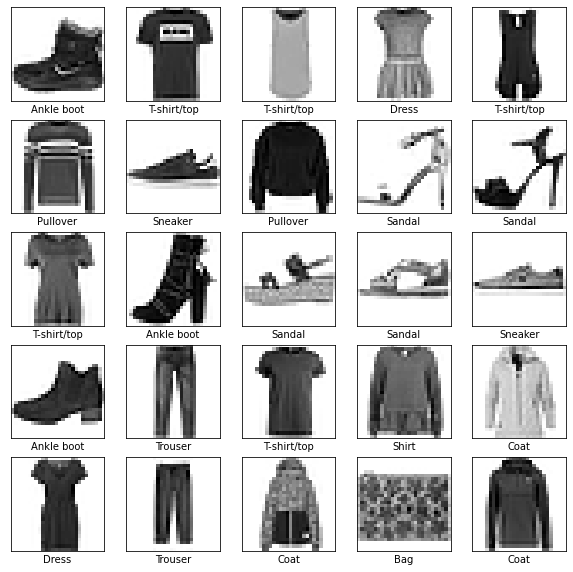

In [27]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Estimator

In [28]:
TRAINING_MODEL_DIR='tmp/checkpoints'

In [29]:
def make_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    return model

In [30]:
# The input function is responsible for feeding data to the estimator

def input_fn():
    BUFFER_SIZE = 10000
    BATCH_SIZE = 64
    
    dataset = tf.data.Dataset.from_tensor_slices( (train_images, train_labels) )
    
    def scale(image, label):
        # images were scaled prior to displaying them
        # image = tf.cast(image, tf.float32)
        # image /= 255

        return {'image': image}, label[..., tf.newaxis]
    
    dataset = dataset.map(scale)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    
    return dataset

In [31]:
def model_fn(features, labels, mode):
    training = (mode == tf.estimator.ModeKeys.TRAIN)
    model = make_model()
    
    predictions = model(features['image'], training=training)

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode, 
            predictions=predictions
        )
    
    # 1) 
    # Note this check for labels is None and then acquiring it from the features
    # This is necessary when exporting the model for training
    
    if labels is None:
        labels = features['label']
        # labels = labels[..., tf.newaxis]
    
    optimizer = tf.compat.v1.train.AdamOptimizer()
    
    # SparseCategoricalCrossentropy takes integer labels (indices) while CategoricalCrossentropy 
    # takes one-hot encodings
    
    loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    reg_losses = model.get_losses_for(None) + model.get_losses_for(features)
    total_loss = loss_fn(labels, predictions) # + tf.math.add_n(reg_losses)

    accuracy = tf.compat.v1.metrics.accuracy(
        labels=labels,
        predictions=tf.math.argmax(predictions, axis=1),
        name='acc_op')

    update_ops = model.get_updates_for(None) + model.get_updates_for(features)
    
    minimize_op = optimizer.minimize(
        total_loss,
        var_list=model.trainable_variables,
        global_step=tf.compat.v1.train.get_or_create_global_step())
      
    # 2)
    # Note that we explicitly name this grouping operation, effectively giving us a way
    # to execute the minimize op above via the session api. Often we can just name the
    # minimize op directly
    
    train_op = tf.group(minimize_op, update_ops, name='train')

    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions,
        loss=total_loss,
        train_op=train_op, 
        eval_metric_ops={'accuracy': accuracy}
    )

In [32]:
STEPS_PER_EPOCH = 5
NUM_EPOCHS = 10

train_spec = tf.estimator.TrainSpec(
    input_fn=input_fn,
    max_steps=STEPS_PER_EPOCH * NUM_EPOCHS
    )

eval_spec = tf.estimator.EvalSpec(
    input_fn=input_fn,
    steps=STEPS_PER_EPOCH
    )

In [33]:
! rm -r 'tmp/checkpoints'

In [34]:
estimator = tf.estimator.Estimator(model_fn=model_fn, model_dir=TRAINING_MODEL_DIR)
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tmp/checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distrib

({'accuracy': 0.759375, 'loss': 0.6820582, 'global_step': 50}, [])

## Export Model

We'll use the `save_model` function below to export for both training and prediction

In [35]:
# Set to True to inspect pbtext version of graph for debugging

SAVE_AS_TEXT=False

In [36]:
def save_model(model_dir, output_dir, serving_input_receiver_fn, mode=tf.estimator.ModeKeys.PREDICT):
    
    estimator = tf.estimator.Estimator(
        model_fn=model_fn,
        model_dir=model_dir
    )
    
    estimator.export_saved_model(
        output_dir,
        lambda:serving_input_receiver_fn(),
        as_text=SAVE_AS_TEXT,
        experimental_mode=mode
    )

## Export Model for Prediction

In [37]:
# The serving input receiver function establishes the signature definitions
# for our exported model

def serving_input_predict_receiver_fn():
    image_shape = [None, 28, 28]
    
    inputs = {
        'image': tf.compat.v1.placeholder(tf.float32, shape=image_shape, name='image')
    }
    
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

In [38]:
EXPORT_MODEL_DIR='tmp/keras-mnist-fashion-estimator-predict'
! rm -r 'tmp/keras-mnist-fashion-estimator-predict'

In [39]:
save_model(TRAINING_MODEL_DIR, EXPORT_MODEL_DIR, serving_input_predict_receiver_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tmp/checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export

### Results

In [47]:
# Set the trailing model id to the value produced by the exporter

! saved_model_cli show --all --dir tmp/keras-mnist-fashion-estimator-predict/1591130205


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28)
        name: image:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: sequential/dense_1/BiasAdd:0
  Method name is: tensorflow/serving/predict


### Tensor/IO

Note in the corresponding model.json that the name and shape of the inputs and outputs matches the values you see in the signature definition. Take special care to note that the name is taken from the layer's name and not from the key in the inputs or outputs dictionary:

```
inputs['image'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 28, 28)
    name: image:0

outputs['output'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 10)
    name: sequential/dense_1/BiasAdd:0
```

In [41]:
! cat model.predict.json

{
	"name": "Keras MNIST Fashion Estimator Preduct Test",
	"details": "Basic Keras Model for Fashion MNSIT dataset exported using the estimator apis",
	"id": "keras-mnist-fashion-estimator-predict",
	"version": "1",
	"author": "doc.ai",
	"license": "Apache License. Version 2.0 http://www.apache.org/licenses/LICENSE-2.0",
	"model": {
		"file": "predict",
		"quantized": false,
		"type": "mnist.fashion.basic",
		"backend": "tensorflow",
		"modes": ["predict"]
	},
	"inputs": [
		{
			"name": "image",
			"type": "array",
			"shape": [-1,28,28]
		}
	],
	"outputs": [
		{
			"name": "sequential/dense_1/BiasAdd",
			"type": "array",
			"shape": [-1,10]
		}
	]
}

I can execute this model on device and it works as expected.

## Export Model for Training

In [42]:
# The serving input receiver function establishes the signature definitions
# for our exported model

# We also include the label here, which allows us to pass the label as an 
# input to the model. This is how we are able to get the label from the 
# features param in the model_fn when labels is None (see [1] in model_fn)

def serving_input_train_receiver_fn():
    image_shape = [None, 28, 28]
    label_shape = [None, 1]
    
    inputs = {
        'image': tf.compat.v1.placeholder(tf.float32, shape=image_shape, name='image'),
        'label': tf.compat.v1.placeholder(tf.int32, shape=label_shape, name='label')
    }
    
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

In [43]:
EXPORT_MODEL_DIR='tmp/keras-mnist-fashion-estimator-train'
! rm -r 'tmp/keras-mnist-fashion-estimator-train'

In [44]:
save_model(TRAINING_MODEL_DIR, EXPORT_MODEL_DIR, serving_input_train_receiver_fn, mode=tf.estimator.ModeKeys.TRAIN)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tmp/checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export

### Results

In [48]:
# Set the trailing model id to the value produced by the exporter

! saved_model_cli show --all --dir tmp/keras-mnist-fashion-estimator-train/1591130207


MetaGraphDef with tag-set: 'train' contains the following SignatureDefs:

signature_def['train']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28)
        name: image:0
    inputs['label'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 1)
        name: label:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['loss'] tensor_info:
        dtype: DT_FLOAT
        shape: ()
        name: sparse_categorical_crossentropy/weighted_loss/value:0
    outputs['metrics/accuracy/update_op'] tensor_info:
        dtype: DT_FLOAT
        shape: ()
        name: acc_op/update_op:0
    outputs['metrics/accuracy/value'] tensor_info:
        dtype: DT_FLOAT
        shape: ()
        name: acc_op/value:0
    outputs['predictions'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: sequential/dense_1/BiasAdd:0
  Method name is: tensorflo

### Tensor/IO

Note in the corresponding model.json that the name, shape, and **data type** of the inputs matches the values you see in the signature definition. Take special care to note that the name is taken from the layer's name and not from the key in the inputs or outputs dictionary:

```
inputs['image'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 28, 28)
    name: image:0

inputs['label'] tensor_info:
    dtype: DT_INT32
    shape: (-1, 1)
    name: label:0
```

Also note that, for training, we'll take the loss value as the preferred output and ignore the other outputs:

```
outputs['loss'] tensor_info:
    dtype: DT_FLOAT
    shape: ()
    name: sparse_categorical_crossentropy/weighted_loss/value:0
```

Finally, although we don't see it in the saved model output, we must also include the op we will call in the model.json file to actually execute training. See [2] in model_fn where we name the `tf.group` op which includes the minimization op.

In [46]:
! cat model.train.json

{
	"name": "Keras MNIST Fashion Estimator Train Example",
	"details": "Basic Keras Model for Fashion MNSIT dataset exported using the estimator apis and an experimental mode for training",
	"id": "keras-mnist-fashion-estimator-train",
	"version": "1",
	"author": "doc.ai",
	"license": "Apache License. Version 2.0 http://www.apache.org/licenses/LICENSE-2.0",
	"model": {
		"file": "train",
		"quantized": false,
		"type": "mnist.fashion.basic",
		"backend": "tensorflow",
		"modes": ["train"]
	},
	"inputs": [
		{
			"name": "image",
			"type": "array",
			"shape": [-1,28,28]
		},
		{
			"name": "label",
			"type": "array",
			"dtype": "int32",
			"shape": [-1,1]
		}
	],
	"outputs": [
		{
			"name": "sparse_categorical_crossentropy/weighted_loss/value",
			"type": "array",
			"shape": [1]
		}
	],
	"train": {
		"ops": [
			"train"
		]
	}
}

## Notes

We can execute training on device after whitelisting a kernel for the `SparseSoftmaxCrossEntropyWithLogits` op (*core/kernels/sparse_xent_op.cc*). The model trains correctly.

**TF 2.2**

For the TF 2.2 version of this model I must also whitelist the `StaticRegexFullMatch` op (*core/kernels/regex_full_match.op*). However that file imports `re2/re2.h`, which the build files do not make available.

RE2 is a regular expression library that would also have to either be compiled into the build or made available as a third party library as nsync and protobuf are.

It looks like this op is needed to check if the model is being saved to an Amazon S3 bucket. This is the node that uses it:

```
node {
      name: "save/StaticRegexFullMatch"
      op: "StaticRegexFullMatch"
      input: "save/Const"
      device: "/device:CPU:*"
      attr {
        key: "_output_shapes"
        value {
          list {
            shape {
            }
          }
        }
      }
      attr {
        key: "pattern"
        value {
          s: "^s3://.*"
        }
      }
    }
```

We have chosen to temporarily enable this op while disabling its use of the RE2 library in such a manner that the op will always return `false`, i.e., no regex match for the string.

Until we have permanently solved this problem by including RE2 in our on-device builds of TensorFlow, do not make calls to `tf.strings.regex_full_match` in your models. If you do you will see a warning in the on-device console logs that this op, although enabled, does not behave correctly.